In [22]:
#run this command if not installed
#!pip install dimod

### Required Modules

In [23]:
#to visualize the network and easy handling of graphs I am using networkx
import networkx as gp
import matplotlib.pyplot as plt
import dimod
import math

In [24]:
#using inbuilt function to find shortest path
#help(gp.shortest_simple_paths)

In [25]:
#we will use pairwise function to convert the continuous nodes (representing path) into edges (where each edge is a node pair)
l= [1,2,4,5,2,4]
ed = list(gp.utils.pairwise(l))
print(ed)

[(1, 2), (2, 4), (4, 5), (5, 2), (2, 4)]


### Sample Input Data

In [26]:
#sample data - to be read from file
#total number of nodes
num_nodes = 20
#Edges are given as u,v,congestion where edges is from u to v and its congestion level is given by the attribute congestion
edges = [
    (0, 1, {'congestion': 3, 'distance': 2}),
    (1, 2, {'congestion': 5, 'distance': 4}),
    (2, 3, {'congestion': 8, 'distance': 3}),
    (3, 4, {'congestion': 2, 'distance': 6}),
    (4, 5, {'congestion': 4, 'distance': 5}),
    (5, 6, {'congestion': 7, 'distance': 2}),
    (6, 7, {'congestion': 6, 'distance': 3}),
    (7, 8, {'congestion': 9, 'distance': 4}),
    (8, 9, {'congestion': 3, 'distance': 6}),
    (9, 10, {'congestion': 2, 'distance': 3}),
    (10, 11, {'congestion': 6, 'distance': 5}),
    (11, 12, {'congestion': 5, 'distance': 4}),
    (12, 13, {'congestion': 8, 'distance': 3}),
    (13, 14, {'congestion': 7, 'distance': 5}),
    (0, 6, {'congestion': 4, 'distance': 5}),
    (1, 7, {'congestion': 6, 'distance': 4}),
    (2, 8, {'congestion': 9, 'distance': 5}),
    (3, 9, {'congestion': 2, 'distance': 6}),
    (4, 10, {'congestion': 8, 'distance': 4}),
    (5, 11, {'congestion': 3, 'distance': 2}),
    (6, 12, {'congestion': 5, 'distance': 6}),
    (7, 13, {'congestion': 6, 'distance': 3}),
    (8, 14, {'congestion': 9, 'distance': 4}),
    (0, 15, {'congestion': 4, 'distance': 7}),
    (15, 16, {'congestion': 2, 'distance': 5}),
    (16, 17, {'congestion': 6, 'distance': 4}),
    (17, 18, {'congestion': 9, 'distance': 3}),
    (18, 19, {'congestion': 3, 'distance': 2}),
    (19, 10, {'congestion': 7, 'distance': 4}),
    (19, 5, {'congestion': 4, 'distance': 6}),
    (16, 13, {'congestion': 5, 'distance': 3}),
    (12, 17, {'congestion': 9, 'distance': 5}),
    (11, 16, {'congestion': 4, 'distance': 3}),
    (9, 15, {'congestion': 3, 'distance': 7}),
    (18, 4, {'congestion': 6, 'distance': 4}),
    (3, 19, {'congestion': 8, 'distance': 3}),
    (7, 10, {'congestion': 5, 'distance': 5}),
    (13, 18, {'congestion': 2, 'distance': 4}),
    (8, 16, {'congestion': 7, 'distance': 3}),
    (2, 12, {'congestion': 9, 'distance': 2}),
    (1, 9, {'congestion': 4, 'distance': 6}),
    (6, 14, {'congestion': 5, 'distance': 3}),
    (14, 0, {'congestion': 8, 'distance': 6})
]


#total number of cars to reroute
no_of_cars = 2
#source-destination pair of each car
'''
Note : input the emergency vehicles first in the serc_dest list
'''
src_dest = [(0,4,1),(0,4,0)]

# Graph formation using NetworkX

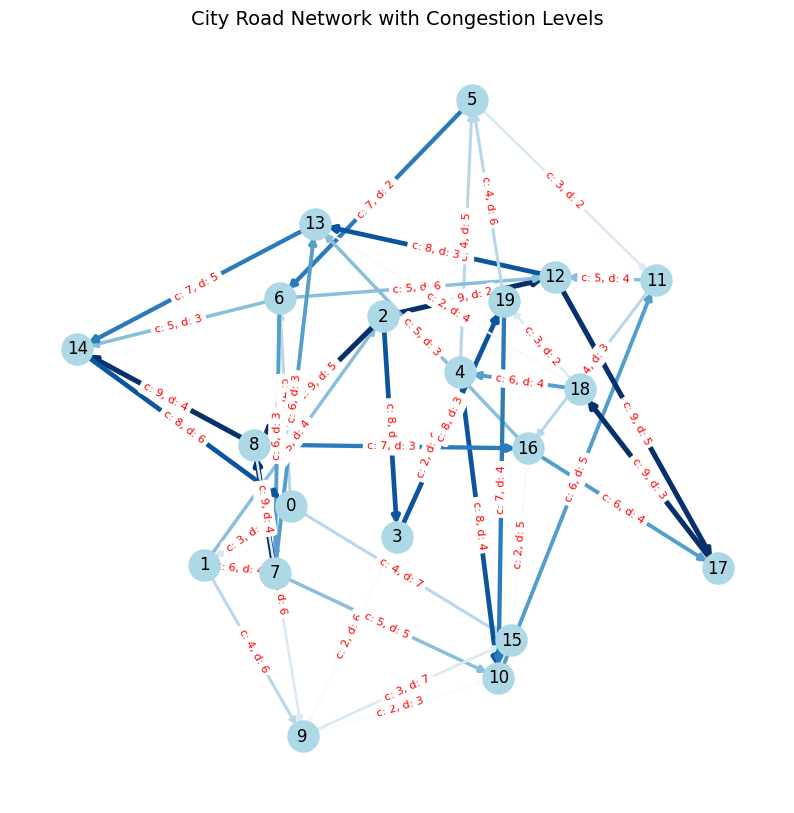

In [43]:
#forming the city's network
#adding nodes
net = gp.DiGraph()
net.add_edges_from(edges)

# Use the spring layout for clearer node placement
pos = gp.spring_layout(net)  # or use kamada_kawai_layout/net.draw_spectral_layout

# Draw nodes
plt.figure(figsize=(10,10))
gp.draw_networkx_nodes(net, pos, node_size=500, node_color='lightblue')

# Draw edges, with edge width based on congestion
congestion = [d['congestion'] for u, v, d in net.edges(data=True)]
gp.draw_networkx_edges(net, pos, width=[1 + c * 0.3 for c in congestion], edge_color=congestion, edge_cmap=plt.cm.Blues)

# Draw labels for nodes
gp.draw_networkx_labels(net, pos, font_size=12, font_color='black')

# Edge labels for congestion and distance
edge_labels = {(u, v): f'c: {d["congestion"]}, d: {d["distance"]}' for u, v, d in net.edges(data=True)}
gp.draw_networkx_edge_labels(net, pos, edge_labels=edge_labels, font_color='red', font_size=8)

# Set plot title
plt.title("City Road Network with Congestion Levels", fontsize=14, color='black')

# Show plot
plt.axis('off')  # Hide axis
plt.show()

# Alternative Routes

In [28]:
def nodeToEdge(node_routes,no_of_car, no_of_route):
    '''the function convert the route in nodes format to edge format (pairwise nodes as shown above)'''
    edge_route = []
    for i in range(no_of_car):
        car_route = []
        for j in range(no_of_route):
                car_route.append(list(gp.utils.pairwise(node_routes[i][j])))
        edge_route.append(car_route)
    return edge_route

In [29]:
def calcJCS(set_a, set_b):
    '''
    the function calculates the jaccard similarity index of two given paths
    '''
    inter = len(set_a.intersection(set_b))
    union = len(set_a.union(set_b))
    return inter/union if union !=0 else 0
def jaccardSimilarityIndex(paths):
    '''
    the function returns the three paths which have least Jaccard Similarity index
    '''
    k = len(paths)
    if(k<=3):return paths
    route = [paths]
    route = nodeToEdge(route,1,k)
    route = route[0]
    result = {}
    for i in range(k):
        for j in range(i+1,k):
            set_a = set(route[i])
            set_b = set(route[j])
            similarity = calcJCS(set_a, set_b)
            result.update({(i,j):similarity})
    srf = sorted(result.items(), key=lambda x: x[1])
    sr=srf[0][0]
    sr2 = srf[1][0]
    final_paths = [paths[sr[0]],paths[sr[1]]]
    if sr2[0] not in sr:
        final_paths.append(paths[sr2[0]])
    else:
        final_paths.append(paths[sr2[1]])
    return final_paths

def edgeWeight(u,v,d):
    return d.get('congestion')/d.get('distance')

def alternativeRoutes(no_of_cars, sd):
    '''finds all the simple paths from source to destination for each car'''
    routes = []
    for i in range(no_of_cars):
        k_paths = list(gp.shortest_simple_paths(net, source = sd[i][0], target=sd[i][1], weight = edgeWeight))
        k_paths = jaccardSimilarityIndex(k_paths)
        routes.append(k_paths)
    return routes
    #return [[[0,1,4],[0,1,3,4],[0,2,4]],[[0,2,5],[0,1,3,4,5],[0,1,4,5]]]

In [30]:
routes  = alternativeRoutes(no_of_cars,src_dest )
print("Source-Destination Pairs for Rerouting:")
ind = 1
for src, dest,emergency in src_dest:
    print(f"Car {ind} from {src} to {dest} : emergency {emergency}")
    ind+=1
print(routes)
print('\nAlternative Routes :\n')
index = 0
for i in range(1,no_of_cars+1):
    print(f'Possible Routes for Car {i}')
    if(len(routes[i-1])<3):
        print("Please give nodes with at least three paths")
        break
    for ch in range(0,len(routes[i-1])):
        l=[]
        for path in routes[i-1][ch]:
            l.append(str(path))
        c="->"
        print(index,":",c.join(l))
        index+=1
        print()

Source-Destination Pairs for Rerouting:
Car 1 from 0 to 4 : emergency 1
Car 2 from 0 to 4 : emergency 0
[[[0, 15, 16, 13, 18, 4], [0, 1, 2, 3, 4], [0, 6, 12, 13, 18, 4]], [[0, 15, 16, 13, 18, 4], [0, 1, 2, 3, 4], [0, 6, 12, 13, 18, 4]]]

Alternative Routes :

Possible Routes for Car 1
0 : 0->15->16->13->18->4

1 : 0->1->2->3->4

2 : 0->6->12->13->18->4

Possible Routes for Car 2
3 : 0->15->16->13->18->4

4 : 0->1->2->3->4

5 : 0->6->12->13->18->4



### Helping Functions

In [31]:
def getOverlappingEdges(route1, route2):
    '''the function returns a list of overlapping edges (pairwise-nodes)'''
    overlaps =[]
    for r1 in route1:
        if r1 in route2:
            overlaps.append(r1)
    return overlaps

In [32]:
def getNonOverlappingEdges(route):
    '''
    returns the unique elements in an array
    '''
    uni = []
    for edge in route:
        if edge not in uni:
            uni.append(edge)
    return uni

In [33]:
def matrixWeight(route_edge, no_of_cars, no_of_routes):
    '''
        Forms the weight matrix (W(ij)) for each binary variable.
        We multiply the weights for the least, second, and best routes by 2, 4, and 8 respectively.
        For emergency vehicles, the weight is doubled overall.
    '''
    Q_weight = {}
    for i in range(no_of_cars):
        emergency = src_dest[i][2]
        path_multipliers = [1.5,2,3]
        l=[]
        for j in range(no_of_routes):
            path = route_edge[i][j]
            path_weight = 0
            total_congestion = 0
            total_distance = 0
            for x, y in path:
                congestion = net[x][y]['congestion']
                distance = net[x][y]['distance']
                total_congestion += congestion
                total_distance += distance
            path_weight = (1.5 * total_congestion) + (1*total_distance)
            l.append((path_weight,j))
        sorted(l)
        ind = 0
        for w,index in l:
            ele=1
            ele*=path_multipliers[ind]
            if emergency == 0:
                ele*=2
            ind+=1
            Q_weight.update({(i, index): ele})
    print(Q_weight)
    return Q_weight
    

In [34]:
def displayMatrix(Q):
    print("-"*100)
    for i in range(0,no_of_cars*no_of_routes):
        for j in range(0,no_of_cars*no_of_routes):
            print(round(Q.get((i,j)),3),"\t|", end="\t")
        print()
        print("-"*100)
    print()

In [35]:
def formQuboMatrix(routes, no_of_car, no_of_routes):
    '''
    forms the QUBO matrix in the form of dictionary
    '''
    #dictionary Q will store the qubo matrix
    Q = {}
    K = 0 # initializing penalty factor
    W = matrixWeight(routes, no_of_car, no_of_routes)
    tot_var = no_of_car*no_of_routes
    #initializing the matrix values to 0
    for i in range(tot_var):
        for j in range(tot_var):
            Q.update({(i,j):0})
    #adding cost function terms
    K = 0
    for i in range(no_of_car):
        car_i_overlap = 0
        for j in range(no_of_routes):
            tot_overlap = []
            for k in range(i+1, no_of_car):
                for m in range(no_of_routes):
                    list_of_overlap = getOverlappingEdges(routes[i][j], routes[k][m])
                    #print(list_of_overlap)
                    Q.update({(i*no_of_routes + j, k*no_of_routes + m):2*len(list_of_overlap)*W[(i,j)]*W[(k,m)]})
                    tot_overlap.extend(list_of_overlap)
            uni_overlap = getNonOverlappingEdges(tot_overlap)
            Q.update({(i*no_of_routes + j, i*no_of_routes + j):len(uni_overlap)*W[(i,j)]*W[(i,j)]})
            car_i_overlap+=len(uni_overlap)
        K = max(K, car_i_overlap)
    #adding penalty terms
    K=K*1000
    print("Penalty Factor :", K)
    for i in range(no_of_car):
        for j in range(no_of_routes):
            for m in range(j+1, no_of_routes):
                Q.update({(i*no_of_routes + j, i*no_of_routes + m):K*2})
            Q[(i*no_of_routes + j, i*no_of_routes + j)] -= K;
    return Q 

In [36]:
routes  = alternativeRoutes(no_of_cars,src_dest)
no_of_routes = len(routes[0])
routes_edge = nodeToEdge(routes,no_of_cars,no_of_routes)
Q = formQuboMatrix(routes_edge, no_of_cars, no_of_routes)
#Q will be an upper triangle matrix
print("QUBO Matrix : for 2 cars and 3 alternative route ( 6 x 6 matrix )")
displayMatrix(Q)

{(0, 0): 1.5, (0, 1): 2, (0, 2): 3, (1, 0): 3.0, (1, 1): 4, (1, 2): 6}
Penalty Factor : 14000
QUBO Matrix : for 2 cars and 3 alternative route ( 6 x 6 matrix )
----------------------------------------------------------------------------------------------------
-13988.75 	|	28000 	|	28000 	|	45.0 	|	0.0 	|	36.0 	|	
----------------------------------------------------------------------------------------------------
0 	|	-13984 	|	28000 	|	0.0 	|	64 	|	0 	|	
----------------------------------------------------------------------------------------------------
0 	|	0 	|	-13955 	|	36.0 	|	0 	|	180 	|	
----------------------------------------------------------------------------------------------------
0 	|	0 	|	0 	|	-14000.0 	|	28000 	|	28000 	|	
----------------------------------------------------------------------------------------------------
0 	|	0 	|	0 	|	0 	|	-14000 	|	28000 	|	
----------------------------------------------------------------------------------------------------
0 	|	0 	|

In [37]:
#runnign the classical solver for re-routing
bqm = dimod.BinaryQuadraticModel.from_qubo(Q)
exact_solver  = dimod.ExactSolver()
response = exact_solver.sample(bqm)
result = list(response.samples())
print(response)
resulting_energy = list(response.data_vectors['energy'])
min_energy = min(resulting_energy)
ct = resulting_energy.count(min_energy)
best_result = []
for i in range(ct):
    best_result.append(list(dict.values(dict(result[i]))))


    0  1  2  3  4  5    energy num_oc.
30  1  0  0  0  1  0 -27988.75       1
12  0  1  0  1  0  0  -27984.0       1
60  0  1  0  0  0  1  -27984.0       1
24  0  0  1  0  1  0  -27955.0       1
62  1  0  0  0  0  1 -27952.75       1
14  1  0  0  1  0  0 -27943.75       1
28  0  1  0  0  1  0  -27920.0       1
8   0  0  1  1  0  0  -27919.0       1
56  0  0  1  0  0  1  -27775.0       1
15  0  0  0  1  0  0  -14000.0       1
31  0  0  0  0  1  0  -14000.0       1
63  0  0  0  0  0  1  -14000.0       1
1   1  0  0  0  0  0 -13988.75       1
3   0  1  0  0  0  0  -13984.0       1
51  0  1  0  1  0  1  -13984.0       1
7   0  0  1  0  0  0  -13955.0       1
33  1  0  0  0  1  1 -13952.75       1
17  1  0  0  1  1  0 -13943.75       1
25  1  0  1  0  1  0 -13943.75       1
61  1  1  0  0  0  1 -13936.75       1
13  1  1  0  1  0  0 -13927.75       1
19  0  1  0  1  1  0  -13920.0       1
35  0  1  0  0  1  1  -13920.0       1
23  0  0  1  1  1  0  -13919.0       1
29  1  1  0  0  1  0 -139

In [38]:
print("minimum energy :",min_energy)
car1_nodes = []
car2_nodes = []
for sol in best_result:
    print("Possible Solution :", sol)
    ind = 0
    for i in range(no_of_cars):
        for j in range(no_of_routes):
            if(sol[ind]==1):
                    print(f'best route for car {i+1}: {routes[i][j]}')
                    if(i==0):car1_nodes = routes[i][j]
                    if(i==1):car2_nodes = routes[i][j]
            ind+=1

minimum energy : -27988.75
Possible Solution : [1, 0, 0, 0, 1, 0]
best route for car 1: [0, 15, 16, 13, 18, 4]
best route for car 2: [0, 1, 2, 3, 4]


Best Solution
Blue represent Car 1 , Green represents Car 2


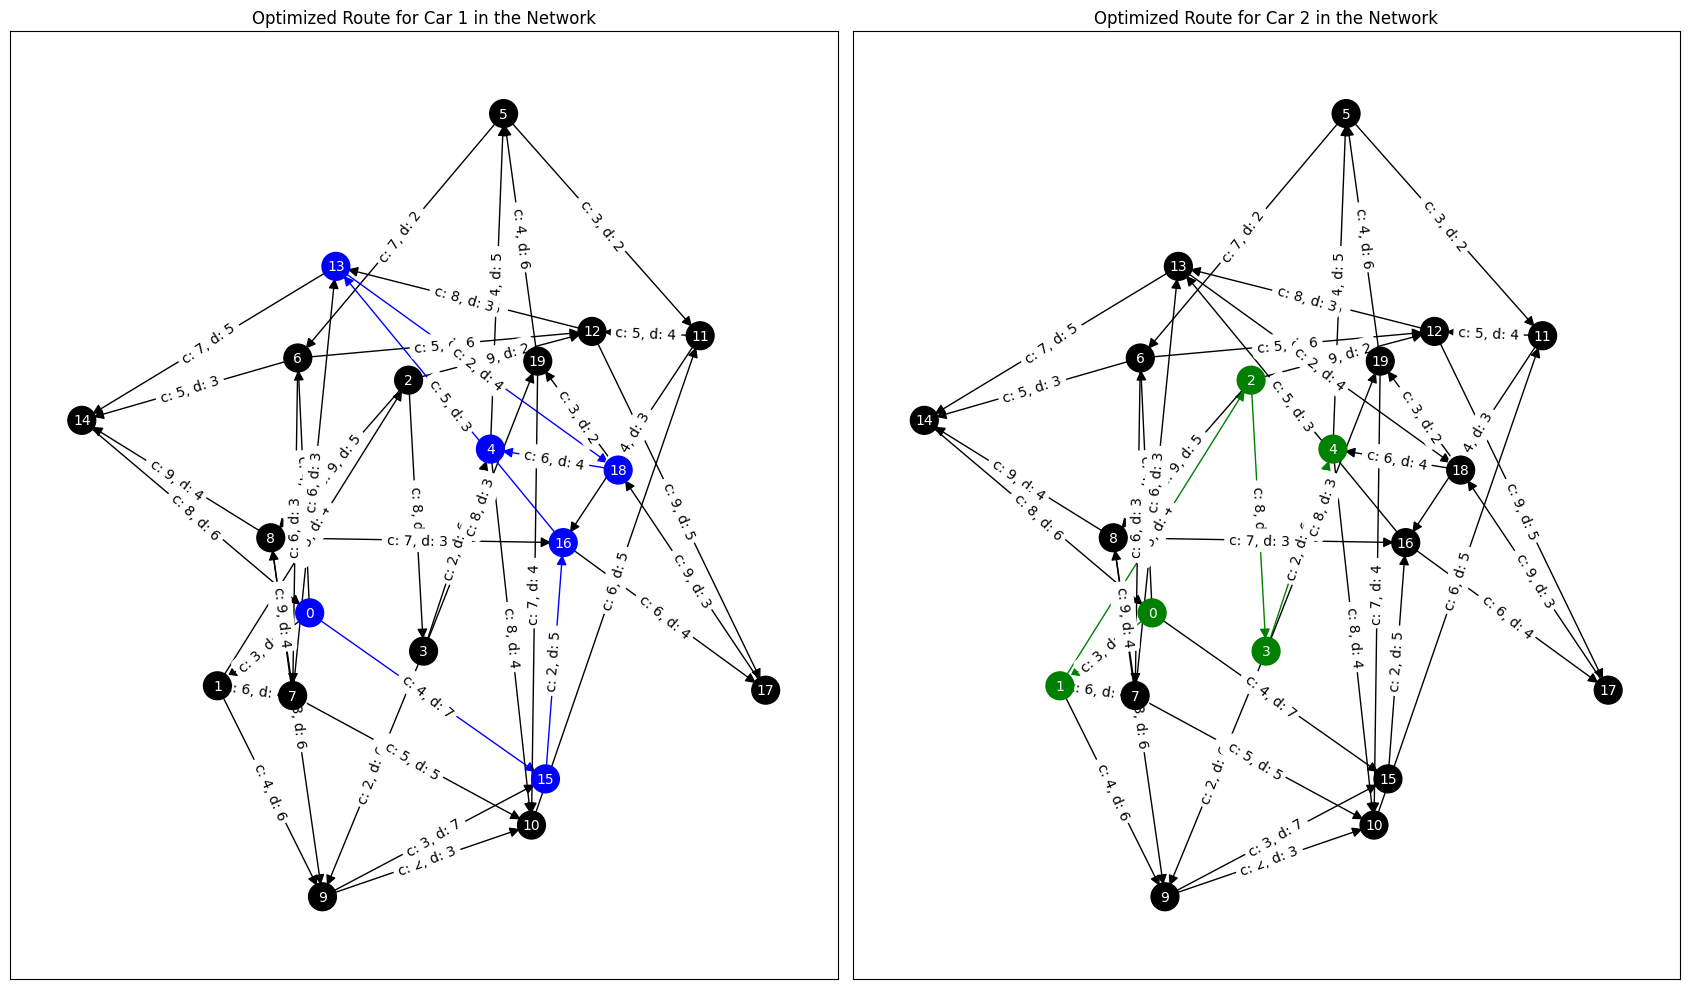

In [44]:
print("Best Solution")
print("Blue represent Car 1 , Green represents Car 2")
car1_edges = list(gp.utils.pairwise(car1_nodes))
car2_edges = list(gp.utils.pairwise(car2_nodes))
edge_labels = {(u, v): f'c: {d["congestion"]}, d: {d["distance"]}' for u, v, d in net.edges(data=True)}
fig, axes = plt.subplots(1, 2, figsize=(17, 10)) 
#car1
node_colors = ['blue' if node in car1_nodes else 'black' for node in net.nodes()]
edge_colors = ['blue' if (u, v) in car1_edges else 'black' for u, v in net.edges()]
gp.draw_networkx_nodes(net, pos, node_color=node_colors, node_size=400,ax=axes[0])
gp.draw_networkx_edges(net, pos, edge_color = edge_colors, arrowstyle='-|>', arrowsize=15,ax=axes[0])
gp.draw_networkx_edge_labels(net, pos, edge_labels=edge_labels,ax=axes[0])
gp.draw_networkx_labels(net, pos, font_size=10, font_color='white',ax=axes[0])
axes[0].set_title("Optimized Route for Car 1 in the Network")

#car2
node_colors_car2 = ['green' if node in car2_nodes else 'black' for node in net.nodes()]
edge_colors_car2 = ['green' if (u, v) in car2_edges else 'black' for u, v in net.edges()]

gp.draw_networkx_nodes(net, pos, node_color=node_colors_car2, node_size=400, ax=axes[1])
gp.draw_networkx_edges(net, pos, edge_color=edge_colors_car2, arrowstyle='-|>', arrowsize=15, ax=axes[1])
gp.draw_networkx_edge_labels(net, pos, edge_labels=edge_labels,ax=axes[1])
gp.draw_networkx_labels(net, pos, font_size=10, font_color='white',ax=axes[1])
axes[1].set_title("Optimized Route for Car 2 in the Network")


plt.tight_layout()
plt.show()

# Traffic Light Optimization

1. Two Phases (Green or Red)
: We can now modify only the green light timing automatically adjusting the red light

2. Fixed Cycle Time
: Each signal has a fixed total cycle time (T), which is important because any adjustment to the green phase time at one intersection will directly affect the cycle times of others (constraint).


In [40]:
def formSignalQubo():
    '''
    the function forms the QUBO matrix with size of each row (no of edges) * (no of bits) where no of bits are determined by the
    the cycle time
    '''
    #defined a fixed cycle time for each signal 
    T = 63
    #matrix for QUBO
    Q = {}
    index = 0
    no_of_edges = net.number_of_edges()
    no_of_bits = 6
    num_variables = no_of_edges * no_of_bits
    #cost part
    
    for u,v,d in net.edges(data = True):
        congestion = d['congestion']
        for bit in range(0,no_of_bits):
            val = -pow(2,bit)*congestion
            ind = index*(no_of_bits) + bit
            Q.update({(ind,ind):val})
        index +=1
        
    #penalty part
    K = 100
    index = 0
    for l in range(no_of_edges):
        #updating non - diagonal
        for bit1 in range(no_of_bits):
            ind1 = index*(no_of_bits) + bit1
            for bit2 in range(bit1 + 1, no_of_bits):
                ind2 = index*(no_of_bits) + bit2
                Q.update({(ind1, ind2) : 2 * K})
        #updating diagonal
        for bit in range(no_of_bits):
            ind = index*(no_of_bits) + bit
            Q.update({ (ind,ind): Q[(ind,ind)] + K*(1-2*T)})
        index += 1
    print(Q)
    return Q
QSignal = formSignalQubo()

{(0, 0): -12503, (1, 1): -12506, (2, 2): -12512, (3, 3): -12524, (4, 4): -12548, (5, 5): -12596, (6, 6): -12504, (7, 7): -12508, (8, 8): -12516, (9, 9): -12532, (10, 10): -12564, (11, 11): -12628, (12, 12): -12504, (13, 13): -12508, (14, 14): -12516, (15, 15): -12532, (16, 16): -12564, (17, 17): -12628, (18, 18): -12505, (19, 19): -12510, (20, 20): -12520, (21, 21): -12540, (22, 22): -12580, (23, 23): -12660, (24, 24): -12506, (25, 25): -12512, (26, 26): -12524, (27, 27): -12548, (28, 28): -12596, (29, 29): -12692, (30, 30): -12504, (31, 31): -12508, (32, 32): -12516, (33, 33): -12532, (34, 34): -12564, (35, 35): -12628, (36, 36): -12508, (37, 37): -12516, (38, 38): -12532, (39, 39): -12564, (40, 40): -12628, (41, 41): -12756, (42, 42): -12509, (43, 43): -12518, (44, 44): -12536, (45, 45): -12572, (46, 46): -12644, (47, 47): -12788, (48, 48): -12509, (49, 49): -12518, (50, 50): -12536, (51, 51): -12572, (52, 52): -12644, (53, 53): -12788, (54, 54): -12502, (55, 55): -12504, (56, 56): -

In [41]:
#running the classical solver 
def classical_solver_signal():
    '''avoid running this function due heavy memory consumption of classical solver'''
    bqm = dimod.BinaryQuadraticModel.from_qubo(QSignal)
    exact_solver  = dimod.ExactSolver()
    response = exact_solver.sample(bqm)
    result = list(response.samples())
    print(response)
    resulting_energy = list(response.data_vectors['energy'])
    min_energy = min(resulting_energy)